<a href="https://colab.research.google.com/github/Gilade98/Machine_Learning_Projects/blob/main/BGU_ML/Ex4_VGG19_Yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Gilade98/Machine_Learning_Projects/blob/main/BGU_ML/Ex4_VGG19_Yolov5.ipynb)



**IT IS HIGHLY RECOMMENDED TO OPEN IN COLAB IN ORDER TO NOT SEE THE REDUNDANT OUTPUTS**

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2025-01-27 06:41:24--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-01-27 06:41:24--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  76.3MB/s    in 4.4s    

2025-01-27 06:41:28 (75.3 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [ ]:
!tar -xvzf /content/102flowers.tgz

Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2025-01-27 06:41:39--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat [following]
--2025-01-27 06:41:39--  https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2025-01-27 06:41:39 (275 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [ ]:
!pip install scipy

In [ ]:
!pip install tensorflow

## Load Data

In [ ]:
import os
import shutil
import random
import scipy.io

# Paths
original_dataset_dir = "/content/jpg"  # Path to your folder of images (all images in one folder)
labels_path = "/content/imagelabels.mat"  # Path to imagelabels.mat
output_dir = "output_splits"  # Path to store the split datasets
os.makedirs(output_dir, exist_ok=True)

# Configuration
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25
repeats = 1  # Number of repeated splits of the data - was a misunderstanding of the assignment

# Load labels from .mat file
labels_data = scipy.io.loadmat(labels_path)
image_labels = labels_data['labels'][0]  # Extract labels (1-based indexing)

# Total number of classes
num_classes = len(set(image_labels))

# Create repeated splits
for i in range(repeats):
    # Create directories for the current split
    split_dir = os.path.join(output_dir, f"split_{i+1}")
    os.makedirs(split_dir, exist_ok=True)
    train_dir = os.path.join(split_dir, "train")
    val_dir = os.path.join(split_dir, "val")
    test_dir = os.path.join(split_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Organize files by class
    class_files = {class_id: [] for class_id in range(1, num_classes + 1)}

    # Populate class_files dictionary
    for idx, class_id in enumerate(image_labels):
        # Image files are named as "image_00001.jpg", "image_00002.jpg", etc.
        image_name = f"image_{idx + 1:05d}.jpg"  # Ensure 1-based indexing
        image_path = os.path.join(original_dataset_dir, image_name)
        if os.path.exists(image_path):
            class_files[class_id].append(image_name)

    # Split and move files for each class
    for class_id, files in class_files.items():
        random.shuffle(files)  # Random shuffle

        # Compute split sizes
        total_files = len(files)
        train_end = int(total_files * train_ratio)
        val_end = train_end + int(total_files * val_ratio)

        # Split the dataset
        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        # Create class-specific folders in train, val, and test directories
        os.makedirs(os.path.join(train_dir, f"class_{class_id}"), exist_ok=True)
        os.makedirs(os.path.join(val_dir, f"class_{class_id}"), exist_ok=True)
        os.makedirs(os.path.join(test_dir, f"class_{class_id}"), exist_ok=True)

        # Move files to their respective directories
        for f in train_files:
            shutil.copy(os.path.join(original_dataset_dir, f), os.path.join(train_dir, f"class_{class_id}", f))
        for f in val_files:
            shutil.copy(os.path.join(original_dataset_dir, f), os.path.join(val_dir, f"class_{class_id}", f))
        for f in test_files:
            shutil.copy(os.path.join(original_dataset_dir, f), os.path.join(test_dir, f"class_{class_id}", f))

    print(f"Split {i+1} completed.")


Split 1 completed.


Sample flower image:


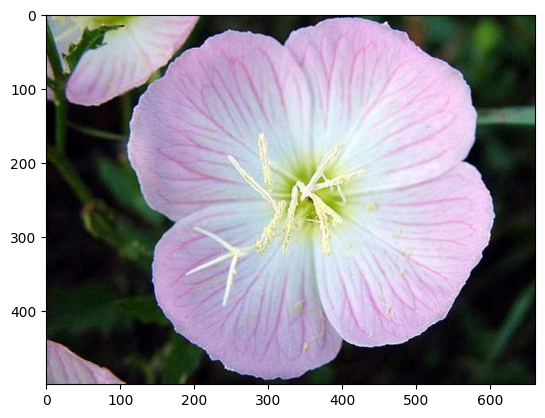

In [ ]:
split1_train_class1_dir="/content/output_splits/split_1/train/class_1"

print("Sample flower image:")
plt.imshow(load_img(f"{os.path.join(split1_train_class1_dir, os.listdir(split1_train_class1_dir)[0])}"))
plt.show()

# VGG19

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Run 1

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, batch_size=32):
  train_datagen = ImageDataGenerator(rescale = 1.0/255. ,
                                    rotation_range=40,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest',
                                    horizontal_flip=True
                                    )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1.0/255.
                                    )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=batch_size,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators("/content/output_splits/split_1/train", "/content/output_splits/split_1/val")


Found 4070 images belonging to 102 classes.
Found 2009 images belonging to 102 classes.


### Modeling

In [ ]:
def create_pre_trained_model():
  pre_trained_model = VGG19(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights='imagenet')

  pre_trained_model.trainable = False

  return pre_trained_model

In [ ]:
from tensorflow.keras.applications import VGG19


pre_trained_model = create_pre_trained_model()

# Print the model summary
pre_trained_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 20,024,384 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19

def create_final_model(pre_trained_model, num_classes, learning_rate=0.0001):
    # Get the output of the last layer of the pre-trained model
    x = pre_trained_model.output  # Automatically fetches the output from block5_pool

    # Add custom layers on top of the pre-trained model
    x = layers.Flatten()(x)  # Flatten the output
    x = layers.Dense(1024, activation='relu')(x)  # Add a dense layer
    x = layers.Dropout(0.2)(x)  # Add dropout for regularization
    x = layers.Dense(num_classes, activation='softmax')(x)  # Add final softmax layer

    # Create the final model
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [ ]:
# Define the number of classes for multi-class classification
num_classes = 102

# Create the final model
final_model = create_final_model(pre_trained_model=pre_trained_model,
                                 num_classes=num_classes)

# Print the model summary
final_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 28,518,566 (108.79 MB)

 Trainable params: 8,494,182 (32.40 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
history = final_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=2
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 - 72s - 559ms/step - accuracy: 0.0872 - loss: 4.2748 - val_accuracy: 0.2240 - val_loss: 3.5322
Epoch 2/100
128/128 - 46s - 358ms/step - accuracy: 0.2302 - loss: 3.5137 - val_accuracy: 0.3340 - val_loss: 2.8769
Epoch 3/100
128/128 - 39s - 308ms/step - accuracy: 0.2988 - loss: 3.0453 - val_accuracy: 0.4365 - val_loss: 2.4215
Epoch 4/100
128/128 - 40s - 316ms/step - accuracy: 0.3558 - loss: 2.7041 - val_accuracy: 0.4953 - val_loss: 2.1503
Epoch 5/100
128/128 - 40s - 309ms/step - accuracy: 0.3980 - loss: 2.4695 - val_accuracy: 0.5281 - val_loss: 1.9360
Epoch 6/100
128/128 - 40s - 312ms/step - accuracy: 0.4364 - loss: 2.2624 - val_accuracy: 0.5565 - val_loss: 1.7993
Epoch 7/100
128/128 - 43s - 338ms/step - accuracy: 0.4649 - loss: 2.1440 - val_accuracy: 0.6117 - val_loss: 1.6407
Epoch 8/100
128/128 - 79s - 615ms/step - accuracy: 0.4985 - loss: 2.0175 - val_accuracy: 0.6083 - val_loss: 1.5857
Epoch 9/100
128/128 - 45s - 352ms/step - accuracy: 0.5184 - loss: 1.9365 - val_accuracy: 0.6

### Plots

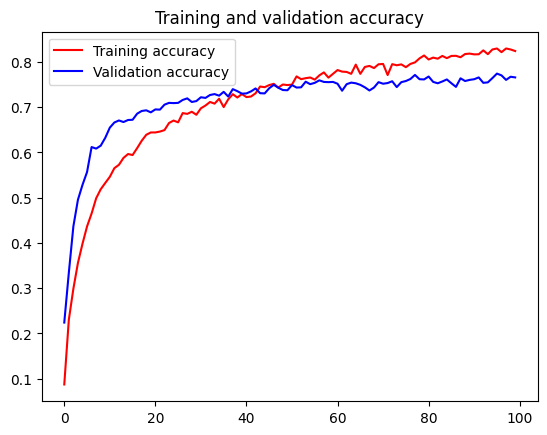

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

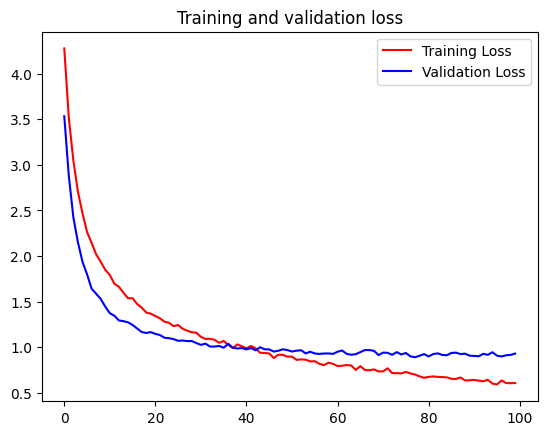

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

## Run 2

Using a bigger batch size, 64, and a larger learning rate, 0.001, keeping the same architecture and training time (epochs)



In [ ]:
train_generator_2, validation_generator_2 = train_val_generators("/content/output_splits/split_1/train", "/content/output_splits/split_1/val", batch_size=64)


Found 4070 images belonging to 102 classes.
Found 2009 images belonging to 102 classes.


### Modeling

In [ ]:
# Not showing again as it is the same architecture
pre_trained_model_2 = create_pre_trained_model()
final_model_2 = create_final_model(pre_trained_model=pre_trained_model,
                                 num_classes=num_classes, learning_rate=0.001)
history_2 = final_model_2.fit(
    train_generator_2,
    validation_data=validation_generator_2,
    epochs=100,
    verbose=2
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 - 75s - 1s/step - accuracy: 0.0867 - loss: 4.4585 - val_accuracy: 0.2439 - val_loss: 3.3614
Epoch 2/100
64/64 - 39s - 615ms/step - accuracy: 0.2361 - loss: 3.3038 - val_accuracy: 0.4276 - val_loss: 2.4575
Epoch 3/100
64/64 - 42s - 655ms/step - accuracy: 0.3192 - loss: 2.7527 - val_accuracy: 0.4778 - val_loss: 2.0371
Epoch 4/100
64/64 - 39s - 617ms/step - accuracy: 0.3821 - loss: 2.4214 - val_accuracy: 0.5411 - val_loss: 1.8012
Epoch 5/100
64/64 - 48s - 745ms/step - accuracy: 0.4403 - loss: 2.1860 - val_accuracy: 0.5650 - val_loss: 1.6242
Epoch 6/100
64/64 - 39s - 614ms/step - accuracy: 0.4693 - loss: 2.0442 - val_accuracy: 0.6028 - val_loss: 1.4859
Epoch 7/100
64/64 - 42s - 651ms/step - accuracy: 0.4921 - loss: 1.9385 - val_accuracy: 0.6282 - val_loss: 1.4127
Epoch 8/100
64/64 - 83s - 1s/step - accuracy: 0.5039 - loss: 1.8375 - val_accuracy: 0.6282 - val_loss: 1.3312
Epoch 9/100
64/64 - 79s - 1s/step - accuracy: 0.5292 - loss: 1.7492 - val_accuracy: 0.6491 - val_loss: 1.2906
Epoc

### Plots

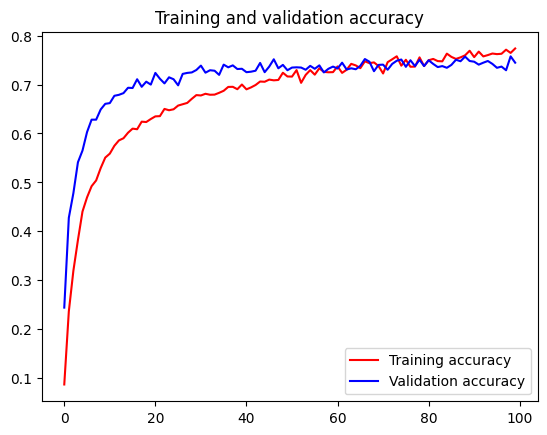

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

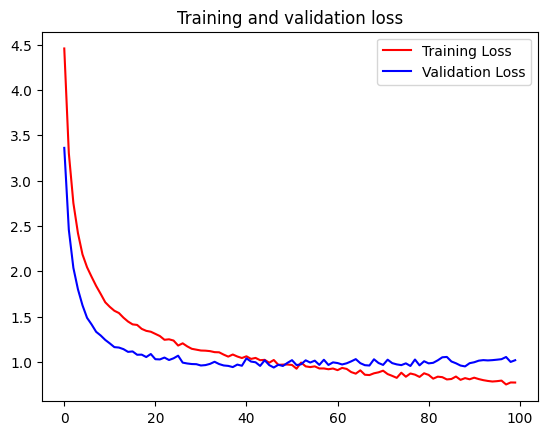

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

## Results

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Test generator
test_generator = test_datagen.flow_from_directory(
    directory='/content/output_splits/split_1/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Ensure this matches your training configuration
    shuffle=False
)


Found 2110 images belonging to 102 classes.


### Run 1 Test

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_generator, verbose=2)

print(f"Test Accuracy: {test_accuracy:.2%}")

66/66 - 16s - 241ms/step - accuracy: 0.7555 - loss: 0.9111
Test Accuracy: 75.55%


### Run 2 Test

In [ ]:
test_loss_2, test_accuracy_2 = final_model_2.evaluate(test_generator, verbose=2)

print(f"Model 2 Test Accuracy: {test_accuracy_2:.2%}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 23s - 352ms/step - accuracy: 0.7133 - loss: 1.1887
Model 2 Test Accuracy: 71.33%


As we can see, the first model did better

#**Yolov5**

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install


Cloning into 'yolov5'...
remote: Enumerating objects: 17265, done.
remote: Total 17265 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17265/17265), 16.09 MiB | 22.00 MiB/s, done.
Resolving deltas: 100% (11855/11855), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 18.4 MB/s eta 0:00:00


## Modeling

In [ ]:
# Print yolov5s.yaml content
with open('models/yolov5s.yaml', 'r') as file:
    yolov5s_config = file.read()

print(yolov5s_config)

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 

In [ ]:
#Hyperparameters
!cat /content/yolov5/data/hyps/hyp.scratch-low.yaml

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01 # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01 # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937 # SGD momentum/Adam beta1
weight_decay: 0.0005 # optimizer weight decay 5e-4
warmup_epochs: 3.0 # warmup epochs (fractions ok)
warmup_momentum: 0.8 # warmup initial momentum
warmup_bias_lr: 0.1 # warmup initial bias lr
box: 0.05 # box loss gain
cls: 0.5 # cls loss gain
cls_pw: 1.0 # cls BCELoss positive_weight
obj: 1.0 # obj loss gain (scale with pixels)
obj_pw: 1.0 # obj BCELoss positive_weight
iou_t: 0.20 # IoU training threshold
anchor_t: 4.0 # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
f

In [ ]:
from utils.downloads import attempt_download
attempt_download('weights/yolov5s-cls.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 10.5M/10.5M [00:00<00:00, 74.6MB/s]



'weights/yolov5s-cls.pt'

## Run 1

In [ ]:
!python classify/train.py \
    --img 640 \
    --batch 16 \
    --epochs 50 \
    --data '/content/output_splits/split_1' \
    --model yolov5s-cls.pt \
    --optimizer Adam \
    --pretrained weights/yolov5s-cls.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-23 11:46:44.914578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 11:46:44.947944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 11:46:44.958435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'


### Processing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the results.csv file
results_path = "runs/train-cls/exp2/results.csv"

# Load the results
results = pd.read_csv(results_path)
results.head()  # Display the first few rows to understand its structure


,epoch,train/loss,test/loss,metrics/accuracy_top1,metrics/accuracy_top5,lr/0
0,0,4.4050,4.4411,0.066351,0.25071,0.000980
1,1,4.1960,4.0190,0.065877,0.29336,0.000960
2,2,4.0996,4.8747,0.097156,0.26351,0.000941
3,3,4.0215,3.9715,0.116110,0.32512,0.000921
4,4,3.9735,3.9364,0.110430,0.34692,0.000901


In [ ]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0                     epoch  50 non-null     int64  
 1                train/loss  50 non-null     float64
 2                 test/loss  50 non-null     float64
 3     metrics/accuracy_top1  50 non-null     float64
 4     metrics/accuracy_top5  50 non-null     float64
 5                      lr/0  50 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 2.5 KB


In [ ]:
print("Columns in the CSV:", results.columns.tolist())


Columns in the CSV: ['                  epoch', '             train/loss', '              test/loss', '  metrics/accuracy_top1', '  metrics/accuracy_top5', '                   lr/0']


In [ ]:
# Strip spaces from column names
results.columns = results.columns.str.strip()

# Verify cleaned column names
print("Cleaned Columns:", results.columns.tolist())


Cleaned Columns: ['epoch', 'train/loss', 'test/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'lr/0']


### Plots

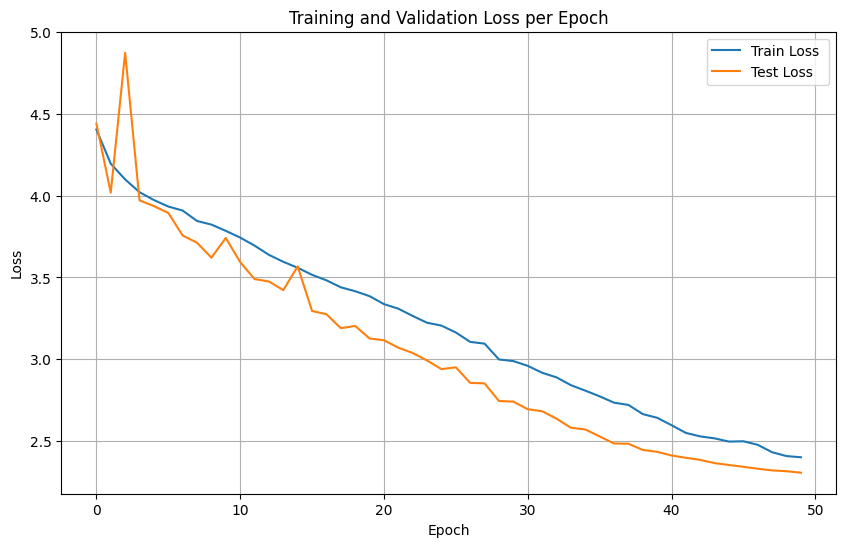

In [ ]:
# Plot training and validation losses
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['train/loss'], label='Train Loss ')
plt.plot(results['epoch'], results['test/loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid()
plt.show()


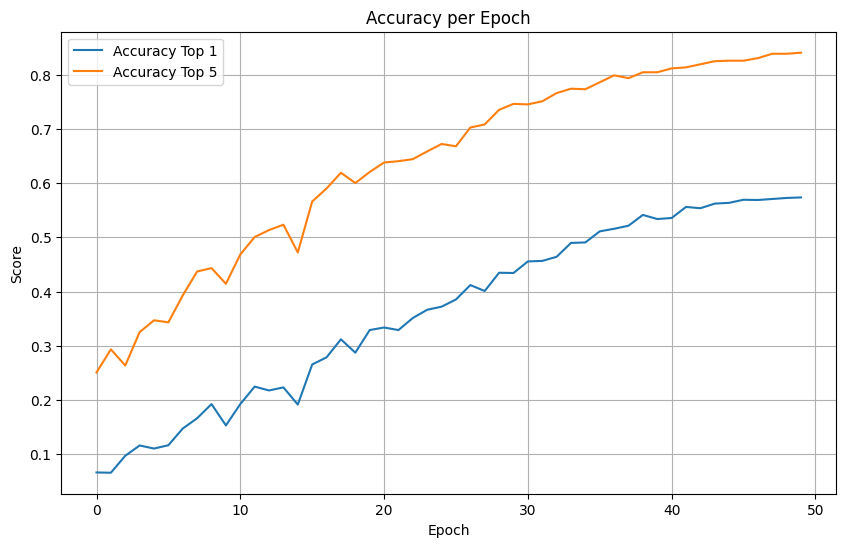

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['metrics/accuracy_top1'], label='Accuracy Top 1')
plt.plot(results['epoch'], results['metrics/accuracy_top5'], label='Accuracy Top 5')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid()
plt.show()


## Run 2

This Run we increase the batch size to 32, epochs to 70, and decrease the learning rate to 0.0001

In [ ]:
!python classify/train.py \
    --img 640 \
    --batch 32 \
    --epochs 70 \
    --data '/content/output_splits/split_1' \
    --model yolov5s-cls.pt \
    --optimizer Adam \
    --lr0 0.0001 \
    --pretrained weights/yolov5s-cls.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-27 06:43:11.448681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 06:43:11.486086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 06:43:11.496398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'


### Processing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the results.csv file
results_path_2 = "/content/yolov5/runs/train-cls/exp/results.csv"

# Load the results
results_2 = pd.read_csv(results_path_2)

# Strip spaces from column names
results_2.columns = results_2.columns.str.strip()

# Verify cleaned column names
print("Cleaned Columns:", results_2.columns.tolist())

Cleaned Columns: ['epoch', 'train/loss', 'test/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'lr/0']


### Plots

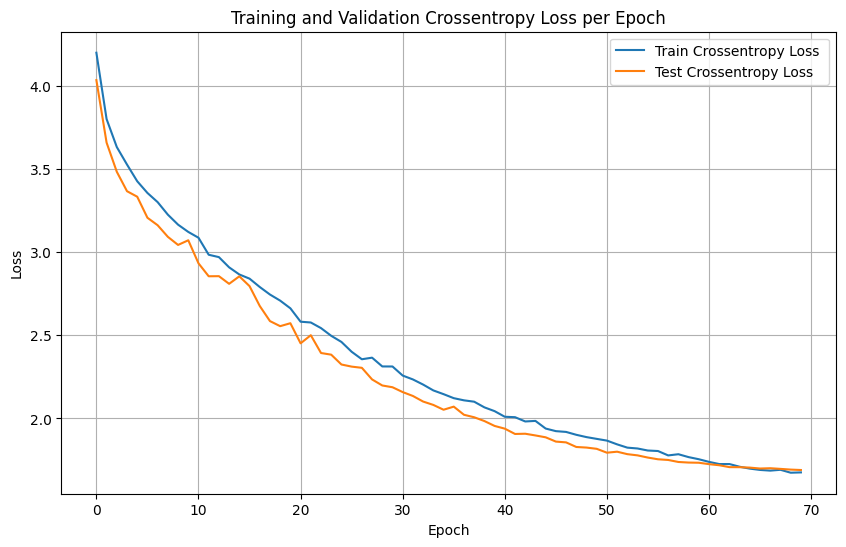

In [ ]:
# Plot training and validation losses
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(results_2['epoch'], results_2['train/loss'], label='Train Crossentropy Loss ')
plt.plot(results_2['epoch'], results_2['test/loss'], label='Test Crossentropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Crossentropy Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

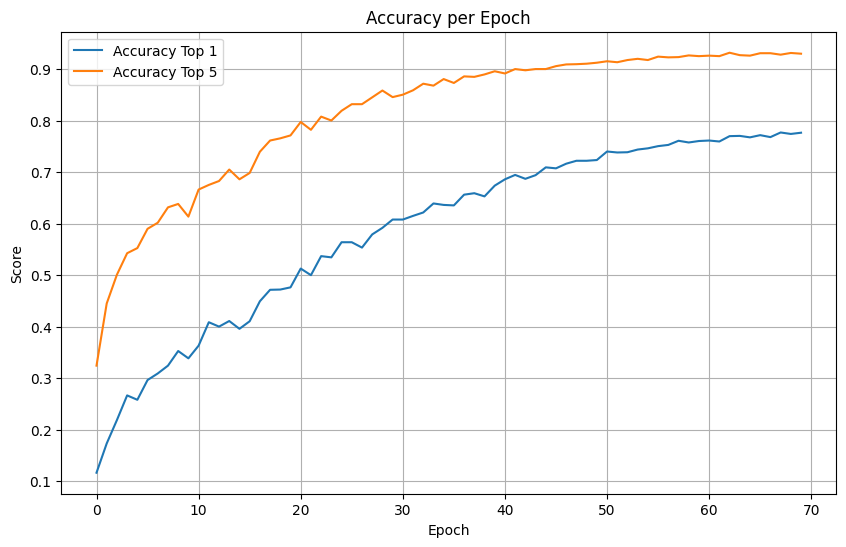

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results_2['epoch'], results_2['metrics/accuracy_top1'], label='Accuracy Top 1')
plt.plot(results_2['epoch'], results_2['metrics/accuracy_top5'], label='Accuracy Top 5')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid()
plt.show()


## Results

### Validation Run 1

In [ ]:
# Validate the model
!python classify/val.py \
    --weights runs/train-cls/exp2/weights/best.pt \
    --data '/content/output_splits/split_1' \
    --img 640

classify/val: data=/content/output_splits/split_1, weights=['runs/train-cls/exp2/weights/best.pt'], batch_size=128, imgsz=640, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
testing:   0% 0/17 [00:00<?, ?it/s]/content/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
testing: 100% 17/17 [00:30<00:00,  1.81s/it]
                   Class      Images    top1_acc    top5_acc
                     all        2110       0.574        0.84
                 class_1          10         0.9         0.9
                class_10          12       0.833           1
               class_100          13       

Not actually saving, see https://github.com/ultralytics/yolov5/issues/10518

In [8]:
# @title
import pandas as pd
from io import StringIO

data = """
Class,Images,top1_acc,top5_acc
all,2110,0.574,0.84
class_1,10,0.9,0.9
class_10,12,0.833,1
class_100,13,0.769,0.846
class_101,15,0.533,0.933
class_102,12,0.667,0.917
class_11,23,0.391,0.565
class_12,23,0.87,0.957
class_13,13,0.692,0.846
class_14,12,0.833,1
class_15,13,0.308,0.923
class_16,11,0.0909,0.545
class_17,22,0.682,0.864
class_18,21,0.0952,0.429
class_19,13,0.538,0.846
class_2,15,0.667,0.8
class_20,14,0.357,0.857
class_21,10,0.2,0.7
class_22,16,0.312,0.875
class_23,24,0.625,0.833
class_24,11,0.364,0.818
class_25,11,0.636,0.818
class_26,11,0.455,0.909
class_27,10,0.4,0.8
class_28,17,0.941,1
class_29,20,0.7,1
class_3,10,0,0.5
class_30,22,0.5,0.864
class_31,13,0.0769,0.385
class_32,12,0,0.333
class_33,12,0.333,1
class_34,10,0.4,0.9
class_35,12,0.667,1
class_36,20,0.45,0.85
class_37,27,0.889,1
class_38,14,0.857,0.929
class_39,11,0,0.636
class_4,14,0,0.357
class_40,18,0.0556,0.389
class_41,33,0.212,0.758
class_42,16,0.5,0.75
class_43,33,0.242,0.636
class_44,24,0.375,0.792
class_45,10,0.2,0.6
class_46,49,0.98,0.98
class_47,18,0.944,1
class_48,19,0.421,0.789
class_49,13,0.846,1
class_5,17,0.0588,0.882
class_50,23,0.913,1
class_51,65,0.662,0.831
class_52,22,0.727,0.864
class_53,24,0.292,0.833
class_54,16,0.5,1
class_55,19,0.895,1
class_56,28,0.929,0.964
class_57,18,0.5,0.722
class_58,29,0.966,0.966
class_59,18,0.944,1
class_6,12,0.5,0.917
class_60,28,1,1
class_61,13,1,1
class_62,15,0.333,0.8
class_63,14,1,1
class_64,13,1,1
class_65,26,0.923,1
class_66,16,1,1
class_67,11,0.364,0.818
class_68,14,0.214,0.5
class_69,14,0.643,1
class_7,10,0.3,0.9
class_70,16,0.875,1
class_71,20,0.8,1
class_72,24,0.208,0.5
class_73,49,0.755,0.959
class_74,44,0.364,0.841
class_75,30,0.933,0.967
class_76,28,0.536,0.714
class_77,64,0.906,0.969
class_78,35,0.714,0.829
class_79,11,0.182,0.636
class_8,22,0.955,0.955
class_80,27,0.37,0.667
class_81,42,0.905,0.976
class_82,28,0.143,0.821
class_83,34,0.294,0.765
class_84,22,0.0909,0.591
class_85,17,0.765,1
class_86,15,0.733,0.867
class_87,17,0.765,1
class_88,39,0.667,0.897
class_89,46,0.674,0.957
class_9,12,0.583,1
class_90,21,0.143,0.619
class_91,19,0.421,0.632
class_92,17,0.353,0.824
class_93,12,0.417,0.667
class_94,41,0.634,0.951
class_95,32,0.344,0.812
class_96,24,0.0833,0.625
class_97,17,0.118,0.529
class_98,21,0.619,0.905
class_99,17,0.0588,0.353
"""

df = pd.read_csv(StringIO(data))

df.head()

,Class,Images,top1_acc,top5_acc
0,all,2110,0.574,0.840
1,class_1,10,0.900,0.900
2,class_10,12,0.833,1.000
3,class_100,13,0.769,0.846
4,class_101,15,0.533,0.933


### Confusion Matrix Run 1

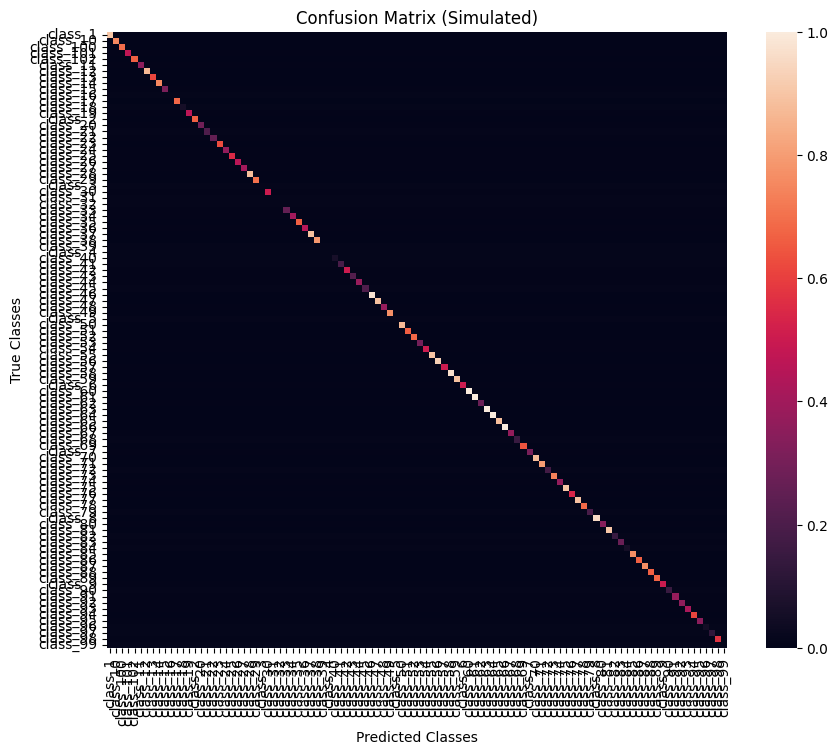

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

# Generate dummy confusion matrix data based on classes and accuracy for visualization
num_classes = len(df) - 1  # Excluding the 'all' row
class_names = df["Class"][1:]

# Simulating a confusion matrix based on top1 accuracy and images for visualization
conf_matrix = np.zeros((num_classes, num_classes))
for i, row in df[1:].iterrows():
    true_positive = int(row["top1_acc"] * row["Images"])
    false_negative = row["Images"] - true_positive
    conf_matrix[i - 1, i - 1] = true_positive  # Diagonal for true positives
    conf_matrix[i - 1, :] += false_negative / (num_classes - 1)  # Distributing false negatives

# Normalize confusion matrix by row
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cbar=True)
plt.title("Confusion Matrix (Simulated)")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()


### Validation Run 2

In [ ]:
!python classify/val.py \
    --weights runs/train-cls/exp/weights/best.pt \
    --data '/content/output_splits/split_1' \
    --img 640

classify/val: data=/content/output_splits/split_1, weights=['runs/train-cls/exp/weights/best.pt'], batch_size=128, imgsz=640, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
testing:   0% 0/17 [00:00<?, ?it/s]/content/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
testing: 100% 17/17 [00:34<00:00,  2.05s/it]
                   Class      Images    top1_acc    top5_acc
                     all        2110       0.776       0.929
                 class_1          10         0.8         0.9
                class_10          12       0.583           1
               class_100          13       0

In [5]:
# @title
from io import StringIO

data = """
Class,Images,top1_acc,top5_acc
all,2110,0.776,0.929
class_1,10,0.8,0.9
class_10,12,0.583,1
class_100,13,0.923,1
class_101,15,0.8,1
class_102,12,1,1
class_11,23,0.435,0.783
class_12,23,0.87,1
class_13,13,1,1
class_14,12,0.917,1
class_15,13,0.615,0.923
class_16,11,0.182,0.909
class_17,22,0.909,0.955
class_18,21,0.571,0.762
class_19,13,0.231,0.769
class_2,15,0.733,0.933
class_20,14,0.643,0.857
class_21,10,0.9,1
class_22,16,0.75,1
class_23,24,0.75,0.875
class_24,11,0.545,0.818
class_25,11,0.727,0.818
class_26,11,0.455,0.909
class_27,10,0.9,1
class_28,17,0.882,1
class_29,20,0.8,0.95
class_3,10,0.5,0.6
class_30,22,0.909,0.955
class_31,13,0.231,0.615
class_32,12,0.167,0.417
class_33,12,0.5,0.833
class_34,10,0.7,1
class_35,12,1,1
class_36,20,0.8,0.95
class_37,27,0.963,0.963
class_38,14,0.929,1
class_39,11,0.364,0.727
class_4,14,0.214,0.357
class_40,18,0.5,0.833
class_41,33,0.667,0.97
class_42,16,0.75,0.875
class_43,33,0.606,0.939
class_44,24,0.75,0.958
class_45,10,0.5,0.8
class_46,49,0.939,0.98
class_47,18,0.889,1
class_48,19,0.789,0.947
class_49,13,1,1
class_5,17,0.588,0.941
class_50,23,1,1
class_51,65,0.908,0.985
class_52,22,1,1
class_53,24,0.875,1
class_54,16,1,1
class_55,19,0.947,1
class_56,28,0.929,1
class_57,18,0.667,0.833
class_58,29,1,1
class_59,18,1,1
class_6,12,0.917,1
class_60,28,1,1
class_61,13,1,1
class_62,15,0.867,0.933
class_63,14,0.857,1
class_64,13,1,1
class_65,26,1,1
class_66,16,1,1
class_67,11,0.545,0.909
class_68,14,0.5,0.786
class_69,14,0.857,1
class_7,10,0.7,0.9
class_70,16,0.938,1
class_71,20,0.95,0.95
class_72,24,0.5,0.917
class_73,49,0.98,1
class_74,44,0.727,0.864
class_75,30,0.933,1
class_76,28,0.75,0.929
class_77,64,0.953,1
class_78,35,0.943,1
class_79,11,0.909,1
class_8,22,0.818,0.909
class_80,27,0.593,0.778
class_81,42,1,1
class_82,28,0.893,0.964
class_83,34,0.706,0.882
class_84,22,0.636,0.864
class_85,17,0.824,0.824
class_86,15,0.867,1
class_87,17,0.824,0.882
class_88,39,0.795,0.974
class_89,46,0.804,0.978
class_9,12,0.5,1
class_90,21,0.238,0.857
class_91,19,0.526,0.947
class_92,17,0.647,0.882
class_93,12,0.25,0.75
class_94,41,0.829,0.854
class_95,32,0.562,0.906
class_96,24,0.542,0.833
class_97,17,0.412,0.706
class_98,21,0.714,1
class_99,17,0.588,0.824
"""

df = pd.read_csv(StringIO(data))

df.head()

,Class,Images,top1_acc,top5_acc
0,all,2110,0.776,0.929
1,class_1,10,0.800,0.900
2,class_10,12,0.583,1.000
3,class_100,13,0.923,1.000
4,class_101,15,0.800,1.000


### Confusion Matrix Run 2

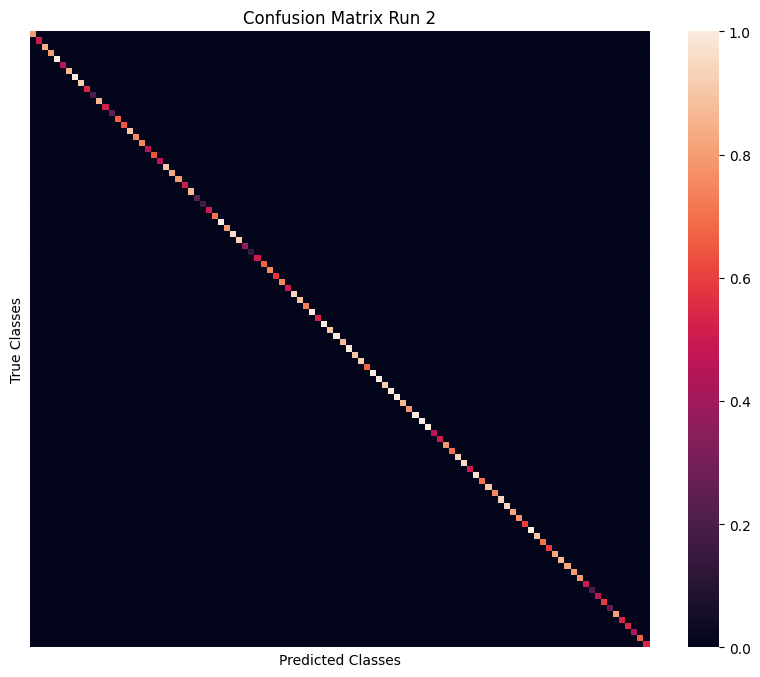

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

# Generate dummy confusion matrix data based on classes and accuracy for visualization
num_classes = len(df) - 1  # Excluding the 'all' row
class_names = df["Class"][1:]

# Simulating a confusion matrix based on top1 accuracy and images for visualization
conf_matrix = np.zeros((num_classes, num_classes))
for i, row in df[1:].iterrows():
    true_positive = int(row["top1_acc"] * row["Images"])
    false_negative = row["Images"] - true_positive
    conf_matrix[i - 1, i - 1] = true_positive  # Diagonal for true positives
    conf_matrix[i - 1, :] += false_negative / (num_classes - 1)  # Distributing false negatives

# Normalize confusion matrix by row
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt='.2f', xticklabels=False, yticklabels=False, cbar=True)
plt.title("Confusion Matrix Run 2")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

## Tests

### Run 1

Loss function based on the training loss function at classify/train.py

In [6]:
import numpy as np

def yolov5_loss(df):

  # Define epsilon to avoid log(0) issues
  epsilon = 1e-10

  # Exclude the "all" row
  df_filtered = df[1:]

  # Define label smoothing factor
  label_smoothing = 0.1 # default value
  num_classes = len(df_filtered)  # Number of classes excluding "all"

  # Compute the smoothed cross-entropy loss
  smoothed_loss = -np.sum(
      df_filtered["Images"] * (
          (1 - label_smoothing) * np.log(df_filtered["top1_acc"] + epsilon) +
          (label_smoothing / num_classes) * np.log(1 / num_classes + epsilon)
      )
  )

  # Compute total number of images
  total_images = df_filtered["Images"].sum()

  # Compute expected train loss (average loss per image in a batch)
  expected_train_loss_per_epoch = smoothed_loss / total_images

  # Print the results
  print(f"CrossEntropy Loss: {expected_train_loss_per_epoch:.4f}")


In [ ]:
overall_top1_acc = df.loc[0, "top1_acc"]
overall_top5_acc = df.loc[0, "top5_acc"]

# Display the overall top1 and top5 accuracy percentages
overall_top1_percent = overall_top1_acc * 100
overall_top5_percent = overall_top5_acc * 100

print(f"Top 1 accuracy: {overall_top1_percent:.2f}%")
print(f"Top 5 accuracy: {overall_top5_percent:.2f}%")

Top 1 accuracy: 57.40%
Top 5 accuracy: 84.00%


In [9]:
yolov5_loss(df)

CrossEntropy Loss: 1.1039


### Run 2

In [ ]:
overall_top1_acc = df.loc[0, "top1_acc"]
overall_top5_acc = df.loc[0, "top5_acc"]

# Display the overall top1 and top5 accuracy percentages
overall_top1_percent = overall_top1_acc * 100
overall_top5_percent = overall_top5_acc * 100

print(f"Run 2 Top 1 accuracy: {overall_top1_percent:.2f}%")
print(f"Run 2 Top 5 accuracy: {overall_top5_percent:.2f}%")

Run 2 Top 1 accuracy: 77.60%
Run 2 Top 5 accuracy: 92.90%


In [7]:
yolov5_loss(df)

CrossEntropy Loss: 0.2774


As we can see, Run 2 performed much better.

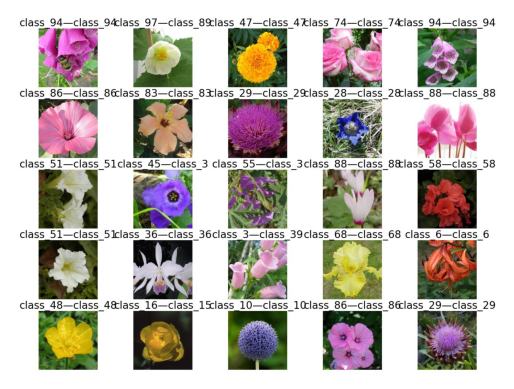

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/yolov5/runs/train-cls/exp/test_images.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()